In [86]:
%%time

# Data Manipulation
import pandas as pd
pd.set_option('use_inf_as_na', True)
import numpy as np
from sklearn.model_selection import train_test_split

# tweets processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords

# Visual modules
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Converting words to numbers (bags of words)
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Pipeline processor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Save model
import pickle

Wall time: 7 ms


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [63]:
#CONSTANTS
TWITTER_LOGO = 'Twitter logo 2012.png'
EXTRA_WORDS = 'extra_words.txt'
TRAIN_FILE = 'train.csv'
SUB_FILE = 'test.csv'

MODEL_FILE = 'some-model'


In [64]:
#Load data and extract inputs and outputs
data_df = pd.read_csv(r'.\Data\train.csv')
data_df = data_df.set_index('id')
#data_df = data_df.fillna(0)

texts = data_df.drop(['target'], axis = 1)
tweets = texts.text
y = data_df.target

In [65]:
texts

keyword location                                               text
id                                                                       
1         NaN      NaN  Our Deeds are the Reason of this #earthquake M...
4         NaN      NaN             Forest fire near La Ronge Sask. Canada
5         NaN      NaN  All residents asked to 'shelter in place' are ...
6         NaN      NaN  13,000 people receive #wildfires evacuation or...
7         NaN      NaN  Just got sent this photo from Ruby #Alaska as ...
...       ...      ...                                                ...
10869     NaN      NaN  Two giant cranes holding a bridge collapse int...
10870     NaN      NaN  @aria_ahrary @TheTawniest The out of control w...
10871     NaN      NaN  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
10872     NaN      NaN  Police investigating after an e-bike collided ...
10873     NaN      NaN  The Latest: More Homes Razed by Northern Calif...

[7613 rows x 3 columns]

In [75]:
full_text = texts.keyword.fillna(' ')+' '+texts.location.fillna(' ') +' '+texts.text.fillna(' ')


In [76]:
full_text

id
1            Our Deeds are the Reason of this #earthqua...
4                   Forest fire near La Ronge Sask. Canada
5            All residents asked to 'shelter in place' ...
6            13,000 people receive #wildfires evacuatio...
7            Just got sent this photo from Ruby #Alaska...
                               ...                        
10869        Two giant cranes holding a bridge collapse...
10870        @aria_ahrary @TheTawniest The out of contr...
10871        M1.94 [01:04 UTC]?5km S of Volcano Hawaii....
10872        Police investigating after an e-bike colli...
10873        The Latest: More Homes Razed by Northern C...
Length: 7613, dtype: object

In [78]:
def make_cloud(word_tokens, image_file_path):
    
    word_str = ' '.join(word_tokens)
    
    mask = Image.open(image_file_path)
    img_mask = Image.new(mode='RGB', size=mask.size, color = (255,255,255))
    img_mask.paste(mask, box = mask)
    
    rgb_array = np.array(img_mask)
    

    cloud = WordCloud(font_path=r'C:\Users\bless\OneDrive\Documents\Python Scripts\Throwaways\Training\Udemy\original\SpamData\01_Processing\wordcloud_resources\OpenSansCondensed-Light.ttf',
                  mask=rgb_array,background_color='black',
                  max_words=600, colormap = 'Set3')

    cloud.generate(word_str.upper())
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(cloud, interpolation='bilinear')

In [98]:
def ProcessTweet(tweet):
    extra_words = (pd.read_table(EXTRA_WORDS, header = None))[0].values.tolist()
    _stopwords = set(stopwords.words('english') + list(punctuation) +
                     ['AT_USER','URL'] + extra_words)
    
    tweet = tweet.lower() # convert tweets to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
    tweet =  re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
    tweet =  word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
    
    return [word for word in tweet if word not in _stopwords]

In [99]:
def test_models(x_train, y_train, x_test, y_test):
    fitted_models = []
    
    models = {'NB': GaussianNB(),
              'SVC': LinearSVC(max_iter = 1000),
              'LR': LogisticRegression(C = 0.6),
              'RF': RandomForestClassifier(n_estimators = 200), 
              'SVC calibrated':CalibratedClassifierCV((LinearSVC(max_iter = 10000)), cv = 2, method = 'sigmoid'),
              'LR calibrated': CalibratedClassifierCV(LogisticRegression(), method = 'sigmoid',cv = 2)}
    
    for name, model in models.items():
        classifier = model.fit(X_train, y_train)
        y_pred = classifier.predict(x_test)
        fitted_models.append(classifier)
        print(name)
        print('Accuracy score:', round(accuracy_score(y_test, y_pred), 2))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
    
    return fitted_models

In [100]:
tweet_tokenizer = FunctionTransformer(ProcessTweet)


Wall time: 48.3 s


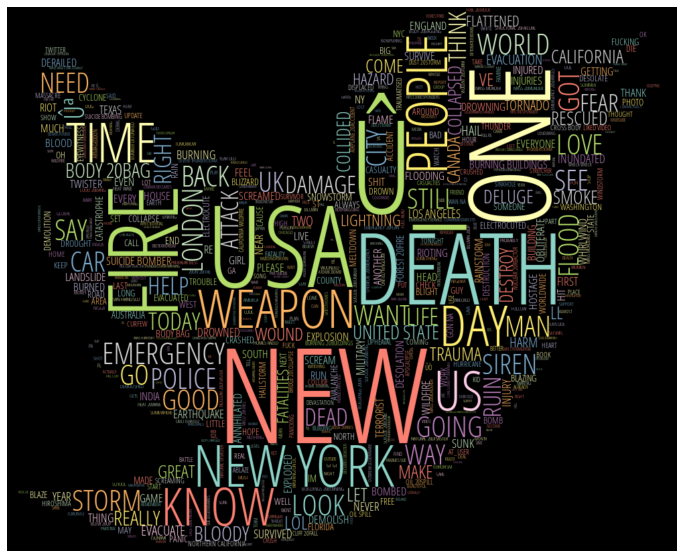

In [101]:
%%time
#Clean tweets and extract words
clean_words_tokened = full_text.apply(ProcessTweet)
words = [word for item in clean_words_tokened for word in item]
clean_words = clean_tweets_tokened.apply(' '.join)

#Make wordcloud
make_cloud(words, TWITTER_LOGO)

In [102]:
#Create bag of words and turn into numpy arrays
vectorizer = CountVectorizer(max_features = 3000, min_df = 5, max_df = 0.7)
X = vectorizer.fit_transform(clean_tweets).toarray()

In [103]:
converter = TfidfTransformer()
X_1 = converter.fit_transform(X).toarray()

In [105]:
%%time
#split arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Instantiate, fit and evaluate classifier
fitted_models = test_models(X_train, y_train, X_test, y_test)


NB
Accuracy score: 0.76
[[714 172]
 [195 442]]
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       886
           1       0.72      0.69      0.71       637

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

SVC
Accuracy score: 0.77
[[719 167]
 [182 455]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       886
           1       0.73      0.71      0.72       637

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523

LR
Accuracy score: 0.8
[[771 115]
 [188 449]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       886
           1       0.80      0.70      0.75       637

    accuracy                           0.